# <font style="color:blue">Object Detection with Region Based Convolutional Neural Network.</font>

In this notebook we will discuss in brief about the two stage object detector which combines region proposals with CNNs - **R-CNN**. 

It has been the state-of-the-art in Object Detection for a long time.

# <font style="color:blue">Understanding Region Proposal in R-CNN</font>
R-CNN methods use the Selective search approach of finding the region proposals instead of exhaustive search. Let us have a look at the evolution of the R-CNN methods.

### <font style="color:green">Sliding Window Approach</font>
  Sliding window is one of the oldest approach in object detection where the input image is split into multiple crops and each crop of the image is classified and if the crop contains a class, then the crop is decided as the bounding box. But this approach is never used in practice as each input image may have 1000s of such crops and each crop passing through the network for classification may take time.
  
### <font style="color:green">Region Proposal (RCNN)</font>
  Image processing techniques are used to make list of proposed regions in the input image which are then sent through the network for classification. But this is computationally more efficient than sliding window approach as only fewer potential crops which may contain the object is classified by the network.
  
  ![](https://cdn-images-1.medium.com/max/800/1*REPHY47zAyzgbNKC6zlvBQ.png)
  Image Source :  [Ross Girshick et al](https://arxiv.org/pdf/1311.2524.pdf)
  
  RCNN is better than sliding window, but its still computationally expensive as the network has to classify all the region proposals. It takes around 30-40s for inference of a single image.
  
  
### <font style="color:green">Fast Region Proposal (Fast RCNN)</font>
  In fast RCNN, rather than getting region proposals and classifying each region proposals, the input image is sent into the CNN network which gives a feature map of the image. Again some region proposals are used but now we get the region proposals from the feature map of the image and these feature maps are classified. This reduces the computation as some of the CNN layers are common for the whole image. 
  
  ![](https://cdn-images-1.medium.com/max/800/1*0pMP3aY8blSpva5tvWbnKA.png)
  Image Source : [Ross Girshick](https://arxiv.org/pdf/1504.08083.pdf)
  

### <font style="color:green">Faster R-CNN</font>
  The idea of Faster R-CNN is to use CNNs to propose potential region of interest and the network is called Region Proposal Network. After getting the region proposals , its just like Fast RCNN, we use every regions for classification.
![](https://www.researchgate.net/profile/Giang_Son_Tran/publication/324549019/figure/fig1/AS:649929152266241@1531966593689/Faster-R-CNN-Architecture-9.png)

# <font style="color:blue">Object Detection with Faster-RCNN</font>
The model comes built-in with the Torchvision library. We can simply load the model using `torchvision.models`. We also want to use the pre-trained weights so that we can check the detection with our own images. (We will see how to train a custom Object Detector using your own data in the next section.)

### <font style="color:green">Input </font>
The pretrained Faster-RCNN ResNet-50 model we are going to use expects the input image tensor to be in the form ```[n, c, h, w]``` 
where 
- n is the number of images
- c is the number of channels , for RGB images its 3
- h is the height of the image
- w is the widht of the image

### <font style="color:green">Output </font>
The model will return
- Bounding boxes [x0, y0, x1, y1]  all all predicted classes of shape (N,4) where N is the number of classes predicted by the model to be present in the image.
- Labels of all predicted classes.
- Scores of each predicted label.



In [ ]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Class labels from official PyTorch documentation for the pretrained model
# Note that there are some N/A's 
# for complete list check https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# we will use the same list for this notebook
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# <font style="color:blue">Detect Objects</font>
We use the function below to load the image and pass it through the model. The output prediction consists of 
- the predicted bounding boxes and 
- class to which it belongs
- confidence of prediction

In [ ]:
def get_prediction(img_path, threshold):
    """
    get_prediction
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.

    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

In [ ]:
def detect_and_display(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    """
    detect_and_display
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
    """
    boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# <font style="color:blue">Examples </font>
Let us have a look at some sample predictions. You should try it out on your own images.

--2020-03-13 20:03:48--  https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg
Resolving www.wsha.org (www.wsha.org)... 104.198.7.33
Connecting to www.wsha.org (www.wsha.org)|104.198.7.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1923610 (1.8M) [image/jpeg]
Saving to: ‘people.jpg’

people.jpg          100%[===================>]   1.83M  1.24MB/s    in 1.5s    

2020-03-13 20:03:50 (1.24 MB/s) - ‘people.jpg’ saved [1923610/1923610]



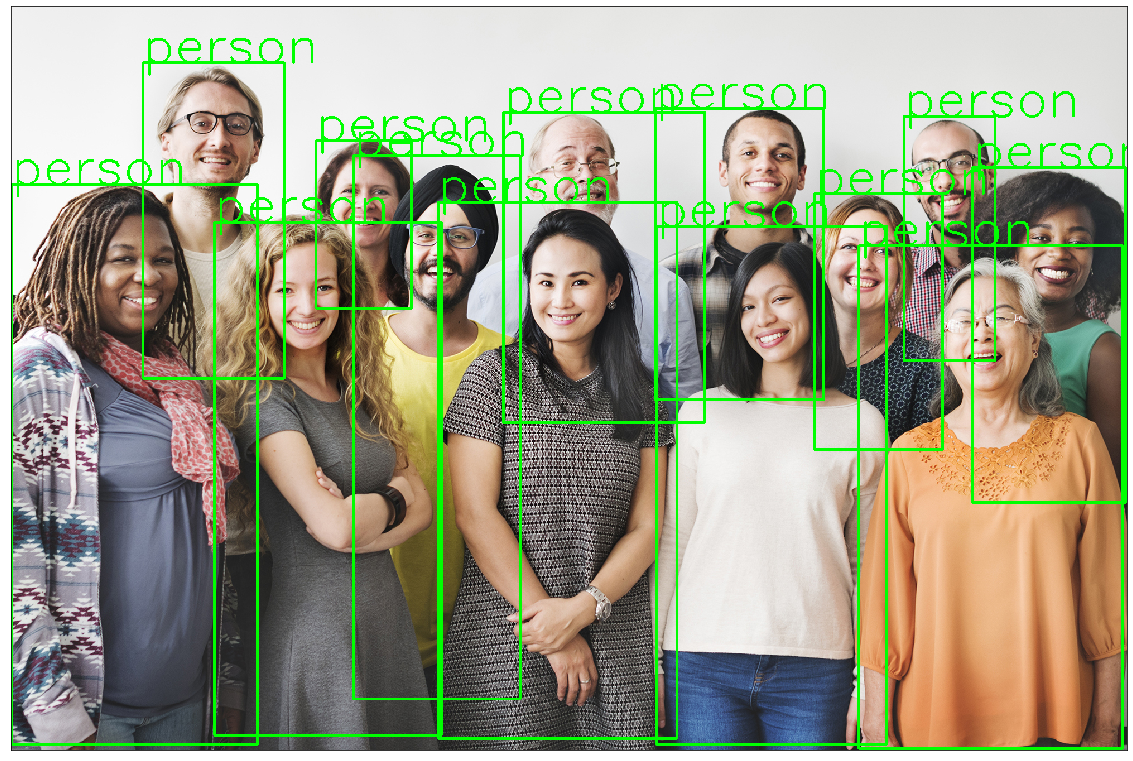

In [3]:
# download an image for inference
!wget https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg -O people.jpg

# use the api pipeline for object detection
# the threshold is set manually, the model sometimes predict 
# random structures as some object, so we set a threshold to filter
# better prediction scores.
detect_and_display('./people.jpg', threshold=0.8)

--2020-03-13 20:03:58--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.8.155
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.8.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2305852 (2.2M) [image/jpeg]
Saving to: ‘cars.jpg’

cars.jpg            100%[===================>]   2.20M  4.96MB/s    in 0.4s    

2020-03-13 20:03:59 (4.96 MB/s) - ‘cars.jpg’ saved [2305852/2305852]



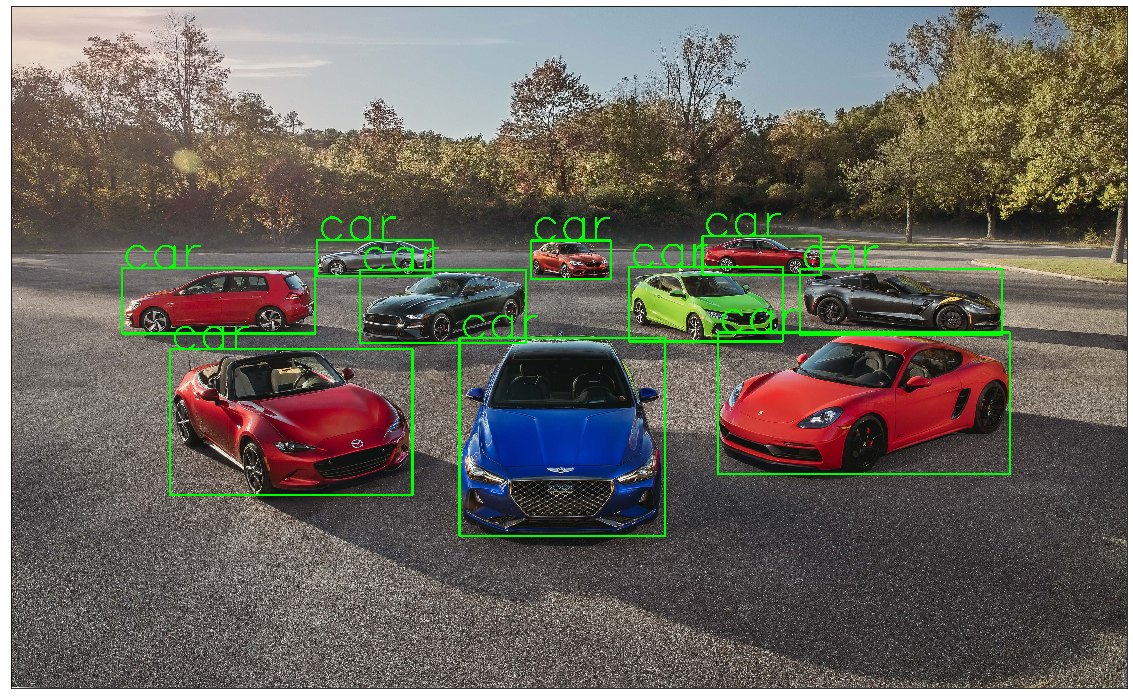

In [4]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O cars.jpg
  
detect_and_display('./cars.jpg', rect_th=6, text_th=5, text_size=5)

--2020-03-13 20:04:03--  https://cdn.pixabay.com/photo/2013/07/05/01/08/traffic-143391_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:15b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 192644 (188K) [image/jpeg]
Saving to: ‘traffic_scene.jpg’

traffic_scene.jpg   100%[===================>] 188.13K  --.-KB/s    in 0.07s   

2020-03-13 20:04:04 (2.58 MB/s) - ‘traffic_scene.jpg’ saved [192644/192644]



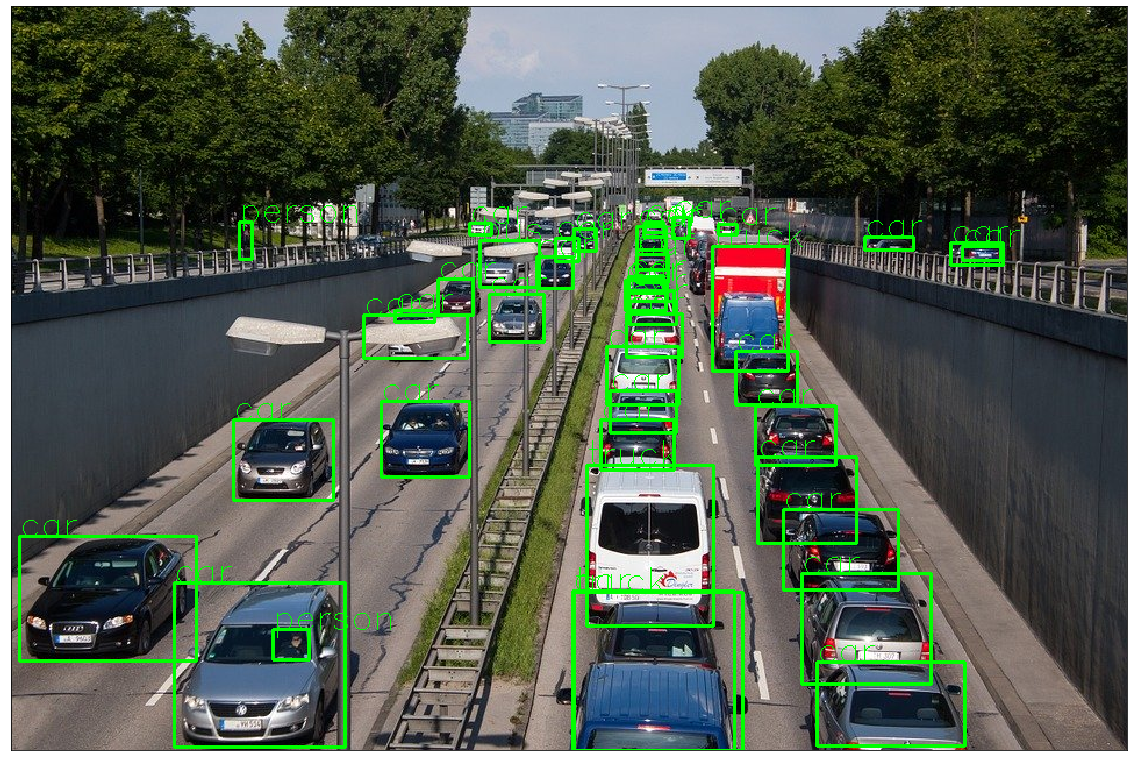

In [5]:
!wget https://cdn.pixabay.com/photo/2013/07/05/01/08/traffic-143391_960_720.jpg -O traffic_scene.jpg
  
detect_and_display('./traffic_scene.jpg', rect_th=2, text_th=1, text_size=1)

# <font style="color:blue">Comparing the inference time of model in CPU & GPU</font>
Let us see how fast the object detection algorithm works. We will do a comparison of the time it takes on GPU vs the CPU

In [11]:
import time

def check_inference_time(image_path, gpu=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    img = Image.open(image_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    if gpu:
        model.cuda()
        img = img.cuda()
    else:
        model.cpu()
        img = img.cpu()
    start_time = time.time()
    pred = model([img])
    end_time = time.time()
    return end_time-start_time

In [12]:
testCount=10
cpu_time = sum([check_inference_time('./traffic_scene.jpg', gpu=False) for _ in range(testCount)])/testCount
gpu_time = sum([check_inference_time('./traffic_scene.jpg', gpu=True) for _ in range(testCount)])/testCount


print('\n\nAverage Time taken by the model with GPU = {}s\nAverage Timen take by the model with CPU = {}s'.format(gpu_time, cpu_time))



Average Time take by the model with GPU = 0.06749477386474609s
Average Time take by the model with CPU = 2.133223843574524s


In the next section, we will learn how to train a custom Object Detector on your own data.